In [1]:
# install Hugging Face transformers library to access pretrained models
!pip install git+https://github.com/huggingface/transformers.git@main

  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-hd3z8e7e
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-hd3z8e7e
  Resolved https://github.com/huggingface/transformers.git to commit ec43d6870aa1afb42a6d2b1b0a03743d3f9b3ce6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.36.0.dev0-py3-none-any.whl size=8234907 sha256=07e9c10619b13e88846237eaa234b1e99c667b49127da9fa05290d6496de6a36
  Stored in directory: /tmp/pip-ephem-wheel-cache-_4qnx72h/wheels/cf/59/82/6492402e887a68975030bf8c06532260abc16abb7ccd8127cc
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [2]:
# install Hugging Face datasets library for data pre-processing
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.7 MB/s eta 0:00:00


In [3]:
# imports

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, BlipForConditionalGeneration
from datasets import load_dataset
from matplotlib import pyplot as plt
import requests
from PIL import Image
from tqdm import tqdm  # progresss bar

`AnnotionFormat` is deprecated and will be removed in v4.38. Please use `transformers.image_utils.AnnotationFormat` instead.


In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# load and process dataset
drive_path = "/content/drive/MyDrive/Colab Notebooks/BC-Project4/project4images/"
dataset = load_dataset("imagefolder", data_dir=drive_path, split="train")

Resolving data files:   0%|          | 0/406 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Panama City, city center skyline and Bay of Panama, Panama, Central America.


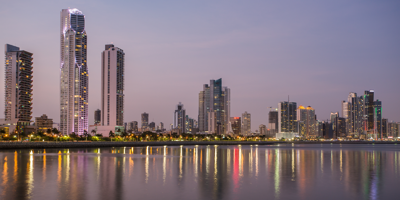

In [6]:
# test that images loaded correctly
image = dataset[0]["image"]
print(dataset[0]["caption"])
image.convert("RGB").resize((400,200))

In [7]:
# how many pieces of data do we have?
len(dataset)

405

In [8]:
# Loading processor
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [9]:
# Loading model (could take a long time)
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [10]:
# Creating the dataset in pyTorch: semi boilerplate
# mut have three below functions to work
# reference: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
# reference: https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing#scrollTo=93od71o_qq_V

class CustomImageDataset(Dataset):
    def __init__(self, dataset, processor):

        # our dataset pulled from load_dataset
        self.dataset = dataset

        # processor is pulled in from AutoProcessor
        self.processor = processor

    # returns the length of the dataset, required func from pytorch
    def __len__(self):
        return len(self.dataset)

    # returns the tensor image and corresponding label in a tuple
    def __getitem__(self, index):
        item = self.dataset[index]
        encoding = self.processor(images=item["image"], text=item["caption"], padding="max_length", return_tensors="pt")
        return {k:v.squeeze() for k,v in encoding.items()}


In [11]:
# load dataset and dataloader
train_dataset = CustomImageDataset(dataset, processor)

# defines parameters of DataLoader, which batches items from dataset instead of running all at once
# this speeds up training
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1)

In [12]:
# define what happens during each epoch
def train_model(epochs):
  # Train the model
  optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

  model.train()

  # loop through user-entered number of training iterations
  for epoch in range(epochs):
    print("Epoch:", epoch)
    loss_array = []

    # loop through each caption
    for idx, batch in enumerate(tqdm(train_dataloader)):
      input_ids = batch.pop("input_ids")
      pixel_values = batch.pop("pixel_values")

      # attention_mask = torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      #                               [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

      outputs = model(input_ids=input_ids,
                      pixel_values=pixel_values,
                      labels=input_ids,
      )#attention_mask=attention_mask)

      loss = outputs.loss
      loss_array.append(loss.item())

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

    print("\nLoss:", loss_array[0], ">", loss_array[-1])

    # save model at every epoch
    model.save_pretrained(f"/content/drive/MyDrive/Colab Notebooks/BC-Project4/model_{epoch}")

In [13]:
# train for one epoch
train_model(1)

Epoch: 0


 18%|█▊        | 73/405 [24:44<1:49:28, 19.79s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (90351625 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 86%|████████▌ | 347/405 [1:56:26<19:01, 19.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (99987864 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 98%|█████████▊| 397/405 [2:13:10<02:39, 19.97s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (94732000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 405/405 [2:15:54<00:00, 20.13s/it]



Loss: 12.999754905700684 > 1.4318764209747314


In [22]:
# train for more epochs
train_model(4)

Epoch: 0


 26%|██▌       | 106/405 [35:39<1:40:01, 20.07s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (99987864 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 52%|█████▏    | 210/405 [1:10:38<1:04:05, 19.72s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (94732000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 60%|██████    | 245/405 [1:22:36<56:33, 21.21s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (90351625 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 405/405 [2:16:35<00:00, 20.24s/it]



Loss: 1.371066927909851 > 1.398636817932129
Epoch: 1


  7%|▋         | 27/405 [09:15<2:07:35, 20.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (99987864 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 32%|███▏      | 130/405 [43:52<1:33:02, 20.30s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (90351625 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 73%|███████▎  | 295/405 [1:39:08<36:37, 19.98s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (94732000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 405/405 [2:16:13<00:00, 20.18s/it]



Loss: 1.3768677711486816 > 1.4154270887374878
Epoch: 2


 63%|██████▎   | 257/405 [1:25:58<51:29, 20.87s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (90351625 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 68%|██████▊   | 277/405 [1:32:43<43:17, 20.29s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (99987864 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 70%|██████▉   | 282/405 [1:34:24<40:44, 19.87s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (94732000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 405/405 [2:15:33<00:00, 20.08s/it]



Loss: 1.4095685482025146 > 1.375710129737854
Epoch: 3


 33%|███▎      | 133/405 [44:44<1:29:46, 19.80s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (99987864 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 69%|██████▉   | 281/405 [1:34:44<40:54, 19.79s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (90351625 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 88%|████████▊ | 356/405 [2:00:27<16:54, 20.71s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (94732000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 405/405 [2:17:54<00:00, 20.43s/it]



Loss: 1.3879646062850952 > 1.3756284713745117


In [2]:
# print the image with the caption
def get_caption(image, rep_penalty=1):
  inputs = processor(images=image, return_tensors='pt')
  pixel_values = inputs.pixel_values

  # set repitition penalty
  generated_ids = model.generate(pixel_values=pixel_values, max_length=20, repetition_penalty=rep_penalty)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

  fig = plt.figure(figsize=(10, 10))
  # plt.rcParams["figure.figsize"] = [2 * i for i in plt.rcParams["figure.figsize"]]
  plt.imshow(image)
  plt.title(generated_caption)
  plt.axis('off')
  plt.show()

In [3]:
def get_caption_quick(image, rep_penalty=1):
  inputs = processor(images=image, return_tensors='pt')
  pixel_values = inputs.pixel_values

  # set repitition penalty
  generated_ids = model.generate(pixel_values=pixel_values, max_length=20, repetition_penalty=rep_penalty)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

  # print images
  print(generated_caption)
  display(image.convert("RGB").resize((400,200)))

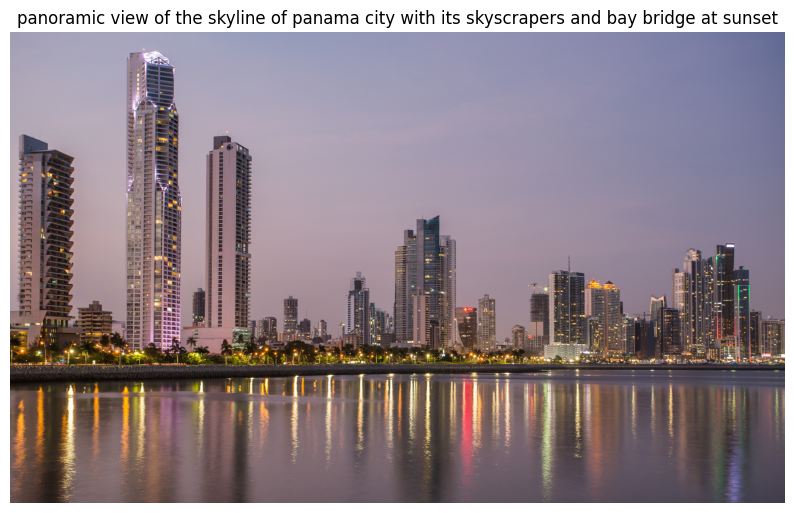

In [20]:
# test with image from dataset
get_caption(dataset[0]["image"], 1.2)

#### **Credits**

Images in this project were obtained from Adobe Stock through an Education License and may not be repurposed by third parties. The Education License permits faculty members and staff members to use, reproduce, archive, modify, and display the asset: for advertising, marketing, promotional, and decoration purposes related solely to the Enterprise, for professional and academic activities related solely to the Enterprise, and not for any other commercial purpose. Students may use, reproduce, archive, modify, and display the asset in all media, solely in connection with course work at the Enterprise, and not for any other commercial or paid purposes. The use of these licensed images is therefore intended for the contributors to this educational project, as part of the edX bootcamp in collaboration with the University of Pennsylvania, and may not be used in other ways.